<a href="https://colab.research.google.com/github/noambassat/SupremeCourtClassifier/blob/main/5_second_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding + first classifier

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold,train_test_split,cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score,make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
import joblib
import ast
import re


In [2]:
data = pd.read_csv("full_final_df.csv")

In [3]:
data

,גוף המסמך,מספר הליך,Outcome of case,שנת פתיחת ההליך,outcome_category
0,"['פסק-דין בתיק רע""פ 7861/03 בבית המשפט העליון ...","רע""פ 7861/03",G R,2003,1
1,"['פסק-דין בתיק רע""פ 8337/04 בבית המשפט העליון ...","רע""פ 8337/04",G R,2004,1
2,"['החלטה בתיק רע""פ 7896/04 בבית המשפט העליון רע...","רע""פ 7896/04",G A,2004,0
3,"['פסק-דין בתיק רע""פ 2038/04 בבית המשפט העליון ...","רע""פ 2038/04",G R,2004,1
4,"['פסק-דין בתיק רע""פ 5978/04 בבית המשפט העליון ...","רע""פ 5978/04",G A,2004,0
...,...,...,...,...,...
771,"[' בבית המשפט העליון רע""פ 4357/01 בפני: כבוד ה...","רע""פ 4357/01",NaN,2001,0
772,"['פסק דין בתיק רע""פ 1218/21 בבית המשפט העליון ...","רע""פ 1218/21",NaN,2021,2
773,"['פסק דין בתיק רע""פ 7316/21 בבית המשפט העליון ...","רע""פ 7316/21",NaN,2021,0
774,"['פסק דין בתיק רע""פ 7951/21 בבית המשפט העליון ...","רע""פ 7951/21",NaN,2021,1


In [4]:
data["outcome_category"].unique()

array([1, 0, 2])

In [5]:
# פונקציה להמרת טקסט שמופיע כרשימה למחרוזת רגילה
def convert_list_to_string(text):
    if isinstance(text, str) and text.startswith("[") and text.endswith("]"):
        try:
            # מנסה להמיר את התוכן בתוך הסוגריים לרשימה אמיתית
            text_list = ast.literal_eval(text)
            # איחוד המחרוזות לרצף טקסט אחד
            return ' '.join(text_list)
        except (ValueError, SyntaxError):
            return text
    return text

# פונקציה לניקוי התווים המיותרים
def clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)  # הפיכת רשימה למחרוזת
    elif isinstance(text, str):
        # הסרת תווי רווח מיותרים ותווים מיוחדים
        text = re.sub(r'\n+', ' ', text)  # הסרת שורות חדשות מרובות
        text = re.sub(r'\\n', '', text)   # הסרת תווי newline \n מהטקסט
        text = re.sub(r'\\xa0', ' ', text)  # הסרת תווי \xa0 מהטקסט
        text = re.sub(r'\s+', ' ', text)  # הסרת רווחים מרובים
        return text.strip()
    return text

# הדפסת שורות לא קריאות לפני המרה
print("שורות לא קריאות לפני המרה:")
print(data["גוף המסמך"].head())

# המרה של הטקסטים הלא קריאים לטקסטים קריאים ושמירה על הדאטה המקורי
data["גוף המסמך"] = data["גוף המסמך"].apply(clean_text)

print("\nשורות לאחר המרה:")
print(data["גוף המסמך"].head())

# file_path = 'full_final_df_cleaned.csv'
# df_full_ra_rap.to_csv(file_path, index=False, encoding='utf-8')

# print(f"הקובץ נשמר בהצלחה בנתיב: {file_path}")


שורות לא קריאות לפני המרה:
0    ['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ...
1    ['פסק-דין בתיק רע"פ 8337/04 בבית המשפט העליון ...
2    ['החלטה בתיק רע"פ 7896/04 בבית המשפט העליון רע...
3    ['פסק-דין בתיק רע"פ 2038/04 בבית המשפט העליון ...
4    ['פסק-דין בתיק רע"פ 5978/04 בבית המשפט העליון ...
Name: גוף המסמך, dtype: object

שורות לאחר המרה:
0    ['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ...
1    ['פסק-דין בתיק רע"פ 8337/04 בבית המשפט העליון ...
2    ['החלטה בתיק רע"פ 7896/04 בבית המשפט העליון רע...
3    ['פסק-דין בתיק רע"פ 2038/04 בבית המשפט העליון ...
4    ['פסק-דין בתיק רע"פ 5978/04 בבית המשפט העליון ...
Name: גוף המסמך, dtype: object


In [6]:
data["Outcome of case"].unique()

array(['G R', 'G A',
       'G R substential matter that was resolved with no consequences on the defendant (as the state consented)',
       'D A', 'D',
       "G A at most- defendant was acquitted of one felony with plaintiff's consent. The sunction remained.",
       'Crim + Sent A G',
       "G WITHDRAWAL V Appellant was aquitted of one felony with appellee's consent. The rest of the appeal was withdrawaled.",
       'Crim + Sent A D', 'Crim + Sub D A', 'G RETURN TO COURT',
       'Crim + Sub D', 'Crim + Sub G R', 'Crim + Sub A D',
       'G R RETURN TO COURT', 'G A Denied at most',
       "G R with the state's consent",
       "G A Granted with the state's consent, the appeal itself was rejected",
       'G R A the appellant was acquitted of some felonies but the punishment remained the same.',
       'G V verdict vacated in part',
       "G R partially and with the state's consent",
       "G A with apellee's consent",
       "G V RETURN TO COURT with appellee's consent", nan], d

In [7]:
data[data["outcome_category"]==2]

,גוף המסמך,מספר הליך,Outcome of case,שנת פתיחת ההליך,outcome_category
85,"['פסק-דין בתיק רע""פ 4422/05 בבית המשפט העליון ...","רע""פ 4422/05",G WITHDRAWAL V Appellant was aquitted of one f...,2005,2
383,"['פסק דין בתיק רע""פ 9680/06 בבית המשפט העליון ...","רע""פ 9680/06",G R A the appellant was acquitted of some felo...,2006,2
396,"['פסק-דין בתיק רע""פ 4305/06 בבית המשפט העליון ...","רע""פ 4305/06",G V verdict vacated in part,2006,2
426,"['החלטה בתיק רע""פ 1801/07 בבית המשפט העליון רע...","רע""פ 1801/07",G R partially and with the state's consent,2007,2
692,"['פסק דין בתיק רע""פ 8866/15 בבית המשפט העליון ...","רע""פ 8866/15",NaN,2015,2
699,"['פסק דין בתיק רע""פ 2430/15 בבית המשפט העליון ...","רע""פ 2430/15",NaN,2015,2
703,"['פסק-דין בתיק רע""פ 10682/05 בבית המשפט העליון...","רע""פ 10682/05",NaN,2005,2
706,"['פסק-דין בתיק רע""פ 2764/05 בבית המשפט העליון ...","רע""פ 2764/05",NaN,2005,2
715,"['פסק דין בתיק רע""פ 1914/10 בבית המשפט העליון ...","רע""פ 1914/10",NaN,2010,2
716,"['החלטה בתיק רע""פ 2533/10 בבית המשפט העליון רע...","רע""פ 2533/10",NaN,2010,2


In [8]:
data["outcome_category"].unique()

array([1, 0, 2])

In [9]:
data["binary_outcome"] = data["outcome_category"].apply(lambda x: 0 if x == 0  else 1)


#### 2 =  others -> 1
####

In [10]:
data

,גוף המסמך,מספר הליך,Outcome of case,שנת פתיחת ההליך,outcome_category,binary_outcome
0,"['פסק-דין בתיק רע""פ 7861/03 בבית המשפט העליון ...","רע""פ 7861/03",G R,2003,1,1
1,"['פסק-דין בתיק רע""פ 8337/04 בבית המשפט העליון ...","רע""פ 8337/04",G R,2004,1,1
2,"['החלטה בתיק רע""פ 7896/04 בבית המשפט העליון רע...","רע""פ 7896/04",G A,2004,0,0
3,"['פסק-דין בתיק רע""פ 2038/04 בבית המשפט העליון ...","רע""פ 2038/04",G R,2004,1,1
4,"['פסק-דין בתיק רע""פ 5978/04 בבית המשפט העליון ...","רע""פ 5978/04",G A,2004,0,0
...,...,...,...,...,...,...
771,"[' בבית המשפט העליון רע""פ 4357/01 בפני: כבוד ה...","רע""פ 4357/01",NaN,2001,0,0
772,"['פסק דין בתיק רע""פ 1218/21 בבית המשפט העליון ...","רע""פ 1218/21",NaN,2021,2,1
773,"['פסק דין בתיק רע""פ 7316/21 בבית המשפט העליון ...","רע""פ 7316/21",NaN,2021,0,0
774,"['פסק דין בתיק רע""פ 7951/21 בבית המשפט העליון ...","רע""פ 7951/21",NaN,2021,1,1



## Training

In [11]:
tokenizer = AutoTokenizer.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")
model = AutoModel.from_pretrained("dean-ai/sentence_transformer_Legal-heBERT")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# פונקציה שמקבלת טקסט ומחזירה את האימבדינג כוקטור
def get_embeddings(text):
    # המרת הטקסט לפורמט מתאים למודל
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # חישוב האימבדינג של המודל
    outputs = model(**inputs)
    # חישוב ממוצע הוקטורים עבור כל טקסט
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings[0]

In [13]:
# ביטוי לבדיקה
keyword = "העותק כפוף לשינויי עריכה וניסוח"

# בדיקה אילו שורות מכילות את הביטוי
rows_with_keyword = data["גוף המסמך"].str.contains(keyword, na=False)

# סינון שורות שלא מכילות את הביטוי
filtered_data = data[rows_with_keyword]

# הדפסת השורות שלא מכילות את הביטוי
rows_without_keyword = data[~rows_with_keyword]
print("שורות שלא מכילות את הביטוי:\n")
text = (rows_without_keyword["גוף המסמך"].to_string(index=False))
formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
print(formatted_text)
print("##*******************************************************####")

# הדפסת מספר השורות שנמחקו
num_removed = len(rows_without_keyword)
print(f"\nמספר השורות שנמחקו: {num_removed}")

# שמירת הנתונים המסוננים לקובץ חדש
filtered_data.to_csv("filtered_data.csv", index=False, encoding='utf-8')
print("\nהנתונים המסוננים נשמרו לקובץ: 'filtered_data.csv'")

data = filtered_data

שורות שלא מכילות את הביטוי:

['פסק-דין בתיק רע"פ 7861/03 בבית המשפט העליון ר...
['פסק-דין בתיק רע"פ 2038/04 ב
בית המשפט העליון ר...
['פסק-דין בתיק רע"פ 5978/04 בבית המשפט העליון ר...
['פסק ד
ין בתיק רע"פ 5062/20 בבית המשפט העליון ר...
['החלטה בתיק רע"פ 813/20 בבית המשפט 
העליון רע"פ...
['פסק דין בתיק רע"פ 3199/20 בבית המשפט העליון ר...
['פסק דין בתיק
 רע"פ 8589/20 בבית המשפט העליון ר...
['החלטה בתיק רע"פ 8471/20 בבית המשפט העליון
 רע"...
[' בבית-המשפט העליון רע"פ 5997/00 בפני: כבודהשו...
[' בבית המשפט העליוןר
ע"פ 843/00 בפני: כבודהנשיא...
[' בבית המשפט העליון רע"פ 3867/00 בפני: כבודהשו...

[' בבית המשפט העליון רע"פ 889/00 בפני: כבוד המש...
[' בבית המשפט העליוןרע"פ2398
/00 בפני: כבוד השופ...
['בבית-המשפט העליון רע"פ 9409/00 בפני: כבוד השו...
[' בבי
ת המשפט העליון בירושליםרע"פ 1557/00 בפני:...
[' בבית המשפט העליון בירושליםרע"פ 1
123/00 בפני:...
['בבית המשפט העליון רע"פ 9288/00 בפני: כבוד השו...
[' בבית המשפט
 העליון רע"פ 4830/00 בפני: כבוד המ...
['פסק דין בתיק רע"פ 5101/16 בבית המשפט העל

binary_outcome
0    674
1     75
Name: count, dtype: int64


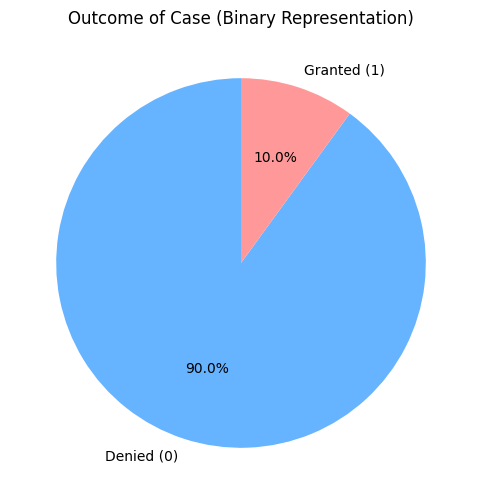

In [14]:
def pie_labels(data):
  binary_counts = data['binary_outcome'].value_counts()
  print(binary_counts)
  labels = ['Denied (0)','Granted (1)']

  plt.figure(figsize=(6, 6))
  plt.pie(binary_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
  plt.title('Outcome of Case (Binary Representation)')

  plt.show()


pie_labels(data)

In [15]:
# פונקציה לחיתוך הטקסט בהתאם לכללים
def trim_text(text,min_length=500,last_sen=30):


    # שמירת אורך מקורי לאבחון
    original_length = len(text)

    # הסרת מספר תווים מסוף הטקסט
    text = text[:-last_sen]

    # חיתוך ל-min_length האחרונים אם הטקסט ארוך יותר מהמינימום
    if len(text) > min_length:
        text = text[-min_length:]

    # הדפסת פידבק רק אם הטקסט עבר שינוי
    if len(text) != original_length:
        print(f"Trimmed Text (Original Length: {original_length}, Trimmed Length: {len(text)}):")
        formatted_text = "\n".join([text[i:i+80] for i in range(0, len(text), 80)])
        print(formatted_text)
        print("##*******************************************************####")
    return text





In [ ]:
# הסרת שורות עם ערכים חסרים בעמודת הטקסט או בעמודת המטרה
data = data.dropna(subset=["גוף המסמך", "outcome_category"])

#400 - 50

# 500 - 30 -< 80% f1

# חיתוך הטקסטים בעמודת "גוף המסמך"
data["גוף המסמך"] = data["גוף המסמך"].apply(lambda x: trim_text(x, 550, 80))

In [ ]:
pie_labels(data)

In [ ]:
# def train_models(data):
#     # עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
#     y_ = data["binary_outcome"].values
#     embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])


#     # הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
#     undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)

#     X_resampled, y_resampled = undersampler.fit_resample(embeddings, y_)

#     # שמירת אינדקסים מקוריים
#     resampled_indices = undersampler.sample_indices_

#     # בדיקת תקינות האינדקסים
#     valid_indices = [i for i in resampled_indices if i < len(data)]
#     if len(valid_indices) < len(resampled_indices):
#         print(f"Warning: {len(resampled_indices) - len(valid_indices)} indices are out of bounds and will be removed.")

#     resampled_indices = valid_indices
#     joblib.dump(resampled_indices, 'second_resampled_indices.pkl')

#     # ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
#     binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
#     if not np.array_equal(y_resampled[:len(resampled_indices)], binary_outcome_resampled):
#         raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

#     # הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
#     classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

#     # התאמת המודל לנתונים המאוזנים
#     classifier.fit(X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)])

#     # הגדרת מדדים לקרוס ולידציה
#     scoring = {
#         'accuracy': make_scorer(accuracy_score),
#         'precision': make_scorer(precision_score, pos_label=1),
#         'recall': make_scorer(recall_score, pos_label=1),
#         'f1': make_scorer(f1_score, pos_label=1)
#     }

#     # ביצוע Cross Validation
#     cv_results = cross_validate(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5, scoring=scoring)

#     # חיזוי תוויות והסתברויות על כל קפל לצורך קונפיושן מטריקס והסתברויות
#     y_pred = cross_val_predict(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5)
#     y_prob = cross_val_predict(classifier, X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)], cv=5, method='predict_proba')[:, 1]  # הסתברות לקלאס 1
#     conf_matrix = confusion_matrix(y_resampled[:len(resampled_indices)], y_pred)

#     # הדפסת התוצאות
#     print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
#     print("Mean Accuracy:", cv_results['test_accuracy'].mean())
#     print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
#     print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
#     print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
#     print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
#     print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
#     print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

#     tn, fp, fn, tp = conf_matrix.ravel()

#     # הדפסת הקונפיושן מטריקס עם תוויות
#     print("Confusion Matrix with Labels:")
#     print(f"True Negatives (TN): {tn}")
#     print(f"False Positives (FP): {fp}")
#     print(f"False Negatives (FN): {fn}")
#     print(f"True Positives (TP): {tp}")

#     print("\nConfusion Matrix:")
#     print(f"[[{tn} {fp}]")
#     print(f" [{fn} {tp}]]")

#     # שמירת האינדקסים המקוריים של הדגימות המסומפלות
#     original_indices = data.index[resampled_indices]

#     # הוספת עמודת הסתברויות
#     data['predicted_probabilities'] = np.nan
#     data.loc[original_indices, 'predicted_probabilities'] = y_prob

#     # שמירת המודל והמשאבים
#     joblib.dump(classifier, 'second_classifier_model.pkl')
#     data.to_csv('updated_data_with_probabilities_2.csv', index=False)

#     print("המודל, התוצאות והנתונים נשמרו בהצלחה.")

#     return data,embeddings,classifier,X_resampled,y_resampled, resampled_indices


In [ ]:
def train_models(data):
    # עדכון עמודת המטרה ואימבדינג לאחר חיתוך הטקסטים
    y_ = data["binary_outcome"].values
    embeddings = np.array([get_embeddings(text) for text in data["גוף המסמך"]])

    # הגדרת undersampler עם יחס של 60-40 לטובת קלאס 0
    undersampler = RandomUnderSampler(sampling_strategy=0.8, random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(embeddings, y_)

    # שמירת אינדקסים מקוריים
    resampled_indices = undersampler.sample_indices_

    # בדיקת תקינות האינדקסים
    valid_indices = [i for i in resampled_indices if i < len(data)]
    if len(valid_indices) < len(resampled_indices):
        print(f"Warning: {len(resampled_indices) - len(valid_indices)} indices are out of bounds and will be removed.")
    resampled_indices = valid_indices
    joblib.dump(resampled_indices, 'second_resampled_indices.pkl')

    # ווידוא התאמה: מיפוי y_resampled לעמודת binary_outcome
    binary_outcome_resampled = data.iloc[resampled_indices]["binary_outcome"].values
    if not np.array_equal(y_resampled[:len(resampled_indices)], binary_outcome_resampled):
        raise ValueError("Mismatch between y_resampled and resampled binary_outcome values!")

    # הגדרת מסווג לוגיסטי עם משקל של 3 עבור קלאס 1
    classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight={0: 1, 1: 3})

    # התאמת המודל לנתונים המאוזנים
    classifier.fit(X_resampled[:len(resampled_indices)], y_resampled[:len(resampled_indices)])

    # הגדרת מדדים לקרוס ולידציה
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, pos_label=1),
        'recall': make_scorer(recall_score, pos_label=1),
        'f1': make_scorer(f1_score, pos_label=1)
    }

    # ביצוע Cross Validation
    cv_results = cross_validate(
        classifier,
        X_resampled[:len(resampled_indices)],
        y_resampled[:len(resampled_indices)],
        cv=5,
        scoring=scoring
    )

    # חיזוי תוויות והסתברויות על כל קפל (Cross Val Predict)
    y_pred = cross_val_predict(
        classifier,
        X_resampled[:len(resampled_indices)],
        y_resampled[:len(resampled_indices)],
        cv=5
    )
    y_prob = cross_val_predict(
        classifier,
        X_resampled[:len(resampled_indices)],
        y_resampled[:len(resampled_indices)],
        cv=5,
        method='predict_proba'
    )[:, 1]  # הסתברות לקלאס 1

    conf_matrix = confusion_matrix(
        y_resampled[:len(resampled_indices)],
        y_pred
    )

    # הדפסת התוצאות
    print("Cross-Validation Accuracy:", cv_results['test_accuracy'])
    print("Mean Accuracy:", cv_results['test_accuracy'].mean())
    print("Cross-Validation Precision for Class 1:", cv_results['test_precision'])
    print("Mean Precision for Class 1:", cv_results['test_precision'].mean())
    print("Cross-Validation Recall for Class 1:", cv_results['test_recall'])
    print("Mean Recall for Class 1:", cv_results['test_recall'].mean())
    print("Cross-Validation F1 Score for Class 1:", cv_results['test_f1'])
    print("Mean F1 Score for Class 1:", cv_results['test_f1'].mean())

    tn, fp, fn, tp = conf_matrix.ravel()

    # הדפסת הקונפיושן מטריקס עם תוויות
    print("Confusion Matrix with Labels:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    print("\nConfusion Matrix:")
    print(f"[[{tn} {fp}]")
    print(f" [{fn} {tp}]]")

    # שמירת האינדקסים המקוריים של הדגימות המסומפלות
    original_indices = data.index[resampled_indices]

    # ------------------ הוספת עמודת 'predicted_probabilities' ------------------ #
    data['predicted_probabilities'] = np.nan
    data.loc[original_indices, 'predicted_probabilities'] = y_prob

    # ------------------ הוספת עמודת 'error_type' (TP, FP, TN, FN) ------------------ #
    # ניצור רשימה של סוג השגיאה/הניבוי עבור כל רשומה ברשמפלינג
    error_types = []
    errors = []
    for true_label, predicted_label in zip(y_resampled[:len(resampled_indices)], y_pred):
        if true_label == 1 and predicted_label == 1:
            error_types.append("TP")
            errors.append(0)
        elif true_label == 0 and predicted_label == 0:
            error_types.append("TN")
            errors.append(0)
        elif true_label == 0 and predicted_label == 1:
            error_types.append("FP")
            errors.append(1)
        elif true_label == 1 and predicted_label == 0:
            error_types.append("FN")
            errors.append(1)
        else:
            error_types.append("UNKNOWN")  # למקרה שמשהו לא צפוי

    # יוצרים עמודה ריקה בנתונים המקוריים
    data['error_type'] = np.nan
    data['errors'] = np.nan
    # מחדירים את הערכים רק לאינדקסים שרשמפלנו
    data.loc[original_indices, 'error_type'] = error_types
    data.loc[original_indices, 'errors'] = errors

    # שמירת המודל והמשאבים
    joblib.dump(classifier, 'second_classifier_model.pkl')
    data.to_csv('SECOND_CLASSIFIER_updated_data_with_probabilities_2.csv', index=False)
    data.to_excel('SECOND_CLASSIFIER_updated_data_with_probabilities_2.xlsx', index=False)

    print("המודל, התוצאות והנתונים נשמרו בהצלחה.")

    return data, embeddings, classifier, X_resampled, y_resampled, resampled_indices


In [ ]:
data,embeddings, classifier, X_resampled,y_resampled, resampled_indices = train_models(data)

In [ ]:
data

In [ ]:
data[data['error_type']=="UNKNOWN"].value_counts()

In [ ]:
data.to_excel('SECOND_CLASSIFIER_updated_data_with_probabilities_2.xlsx', index=False)

In [ ]:
def print_FN(data, classifier, X_resampled, y_resampled, resampled_indices):
    # חיזוי תוויות על כל קפל לצורך זיהוי FN
    y_pred = cross_val_predict(classifier, X_resampled, y_resampled, cv=5)

    # חיזוי הסתברויות
    y_prob = cross_val_predict(classifier, X_resampled, y_resampled, cv=5, method='predict_proba')[:, 1]

    # איתור האינדקסים של FN - תווית אמיתית היא 1 והתחזית היא 0
    fn_indices = np.where((y_resampled == 1) & (y_pred == 0))[0]

    # ודא ש-resampled_indices הוא numpy array
    resampled_indices = np.array(resampled_indices)

    # מיפוי האינדקסים של FN לאינדקסים המקוריים של הנתונים
    original_fn_indices = resampled_indices[fn_indices]

    # קריאת פסקי הדין והערכים בעמודות "Outcome of case", "binary_outcome", "Predicted" ו-"Probability" עבור הדוגמאות שמזוהות כ-FN
    false_negative_rows = data.iloc[original_fn_indices]
    false_negative_probabilities = y_prob[fn_indices]  # ההסתברויות של המודל עבור FN
    false_negative_predicted = y_pred[fn_indices]  # התחזיות של המודל עבור FN

    # ווידוא סינכרון מוחלט של האינדקסים
    if len(false_negative_rows) != len(false_negative_predicted):
        raise ValueError("Mismatch between FN rows and predicted labels!")

    # הדפסת פסקי הדין של FN בצורה מפורמטת עם הערכים המקוריים, התחזית, וההסתברות
    print("False Negative Cases (True Label: 1, Predicted Label: 0):")
    print("=" * 80)

    for i, (index, row, predicted, probability) in enumerate(zip(original_fn_indices, false_negative_rows.iterrows(), false_negative_predicted, false_negative_probabilities), 1):
        _, row_data = row
        print(f"\nCase {i}:")
        print("-" * 80)
        print("Index in Original Data:")
        print(index)
        print("\nOriginal Outcome of Case:")
        print(row_data["Outcome of case"])
        print("\nBinary Outcome (True Label):")
        print(row_data["binary_outcome"])
        print("\nPredicted Label:")
        print(predicted)
        print("\nPredicted Probability:")
        print(f"{probability:.4f}")
        print("\nDocument Body:")
        formatted_text = "\n".join(row_data["גוף המסמך"][j:j + 80] for j in range(0, len(row_data["גוף המסמך"]), 80))
        print(formatted_text)
        print("-" * 80)

    print("=" * 80)


In [ ]:
print_FN(data,classifier,X_resampled,y_resampled, resampled_indices)